# Projet d'optimisation : chauffage d'un bâtiment résidentiel
#### *Sebastian Partarrieu & Clement Desroches*

# 1. Modélisation

### Question 1

En premier lieu, on cherche à effectuer un modèle plausible compte tenu des données fournies.
Pour ce modèle, nous allons faire directement plusieurs hypothèses: 
- le chauffage est exclusivement électrique, c'est justifié ces dernières années 
- on suppose que l'énergie utilisée par la maison est exclusivement dûe au chauffage (c'est ce qu'on cherche à minimiser). Rajouter des sources de consommation d'énergies externes ne nous intéresse pas ici.

Ainsi la fonction à minimiser reste la facture d'électricité. On note $E_p$ ($E_c$) l'énergie consommée par la maison en heure pleine (creuse), $t_p$ ($t_c$) le tarif en heures pleines (creuses). On note M le montant à payer pour la consommation d'électricité.

Alors:
<center> $M = E_c * t_c + E_p * t_p \tag{1}$ </center>  est la quantité que l'on sera amené à minimiser dans la deuxième partie de ce projet.

### Question 2

Nous allons essayer de proposer un modèle de la température intérieure de la maison. Tout d'abord l'on suppose que la maison a la forme d'un cube.

Les différentes sources de transferts thermiques sont :
- le chauffage intérieur qui fournit une puissance $p_c(t)$
- perte thermique à travers les murs que l'on caractérise par une perte de transfert thermique qu'on caractérise par un coefficient de perte $a$ qui sera déterminé par la suite.
    Si l'on suppose que la maison est un cube de coté l, et les murs sont d'épaisseur $e_{mur}$ et le plafond $e_p$.
    Pour un mur on obtient (On néglige la convection à l'intérieur de la maison) $R_{eq/mur} = \frac{1}{h*S_{mur}} + \frac{e_{mur}}{\lambda_{mur} * S_{mur}}$
    
    Donc pour 4 murs (en parallèles) : $ R_{eq/ 4murs} = \frac{R_{eq/mur}}{4}$    
    
    Pour le plafond : $R_{eq/p} = \frac{1}{h*S_{p}} + \frac{e_{p}}{\lambda_p * S_{p}}$
    
    Donc pour la maison en global : $R_{eq/ maison} = (\frac{1}{R_{eq/p}} + \frac{1}{R_{eq/4murs}})^{-1}$
    
    Alors on obtient $a = \frac{1}{R_{eq/maison}}$
    
- rayonnement thermique : 
    $I_s(t) * S_{maison} * b$ (b étant le coefficient d'atténuation et en fonction de la géométrie, moyenné sur les quatres murs et le toit, $S_{maison}$ la surface extérieure de la maison et $I_s(t)$ le flux solaire moyenné sur les quatres murs et le toit) qui dépend de l'heure de la journée et donc du temps.
    Détaillons le coefficient b : il serait la multiplication de deux facteurs : le coefficient d'atténuation dûe aux nuages et autres atténuations du rayonnement (dur à quantifier) et du facteur de forme dépendant de la géométrie de la maison. 
- On ne considère pas d'éventuels échanges avec le sol, ni de production de chaleur à l'intérieur de la maison par les habitants ou d'autres équipements électriques. On considère donc une maison vide parfaitement isolé du sol.
    
    
   
Finalement l'équation qui régit la dynamique de température de l'air à l'intérieur de la maison est: 
       <center> $C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + p_c(t) + I_s(t) * S * b \tag{2}$    </center>

### Question 3

Avant de discrétiser la dynamique mis en place précedemment on représente les données fournies pour pouvoir ensuite identifier les paramètres adéquats de la modélisation précédente. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd

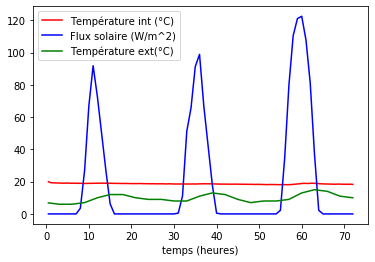

In [2]:
#visualisation de données
df = pd.read_csv('donnees-projet-gr4.txt', header = None,  delimiter='\t')
X, Y1, Y2, Y3 = np.array(df[0]), np.array(df[1]), np.array(df[2]), np.array(df[3])
plt.xlabel('temps (heures)')
plt.plot(X, Y1, c='r', label = 'Température int (°C)')
plt.plot(X, Y2, c='b', label = 'Flux solaire (W/m^2)')
plt.plot(X, Y3, c='g', label = 'Température ext(°C)')
plt.legend(loc='upper left')
plt.show()

On voit directement que la température à l'intérieur de la maison reste constante au cours du temps, sans chauffage a priori ce qui nous amènera à éliminer le terme $p_c(t)$ dans l'équation (2) . On sera amené à changer la température extérieure et le niveau de confort demandé à l'intérieur (température intérieure) plus tard dans le sujet.  


Pour l'instant, reprennons l'équation décrite précedemment sans terme de chauffage, $C_{air}*\frac{\partial{T_{int}(t)}}{\partial{t}} = a*(T_{ext}(t)-T_{int}(t)) + I_s(t) * S * b$. On connaît $C_{air} = c_{air}V_{maison}$ avec $c_{air} = 1,256  kJ.m^{-3}.K^{-1}$ la capacité thermique volumique de l'air. On connaît l'évolution de $T_{int}$, $T_{ext}$ et $I_s(t)$. Il s'agit donc d'estimer et identifier les paramètres $S_{maison}$, $a$ et $b$. Sachant que b peut être déduit de notre choix de modélisation de la maison comme cube...